<a href="https://colab.research.google.com/github/sierrahotel777/220701251-CS19P18-DLC-Experiments/blob/main/DLC_4_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Download and Load the Dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.JFH6PT_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


2. Analysis and Preprocessing

In [2]:
IMG_SIZE = 160
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)

3. Build Model Using Transfer Learning

In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


4. Compile and Fit the Model

In [4]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
                    epochs=5,
                    validation_data=ds_test)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 73s 95ms/step - accuracy: 0.9309 - loss: 0.1695 - val_accuracy: 0.9779 - val_loss: 0.0628
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9782 - loss: 0.0623 - val_accuracy: 0.9802 - val_loss: 0.0590
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9822 - loss: 0.0519 - val_accuracy: 0.9819 - val_loss: 0.0570
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.9830 - loss: 0.0502 - val_accuracy: 0.9813 - val_loss: 0.0590
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.9848 - loss: 0.0457 - val_accuracy: 0.9802 - val_loss: 0.0589


5. Perform Prediction on Test Data

In [5]:
import numpy as np

for images, labels in ds_test.take(1):
    predictions = model.predict(images)
    predicted_labels = (predictions > 0.5).astype("int32")
    print("Predicted labels:", predicted_labels.flatten())
    print("True labels:", labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted labels: [0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0]
True labels: [0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0]


6. Calculate Performance Metrics

In [6]:
SHORTENED_TEST_SIZE = 100

ds_test_short = ds_test.take(SHORTENED_TEST_SIZE)

y_true = []
y_pred = []

for images, labels in ds_test_short:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype("int32")
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))


              precision    recall  f1-score   support

         Cat       0.99      0.97      0.98      1574
         Dog       0.97      0.99      0.98      1626

    accuracy                           0.98      3200
   macro avg       0.98      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200



7. Visualization of Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


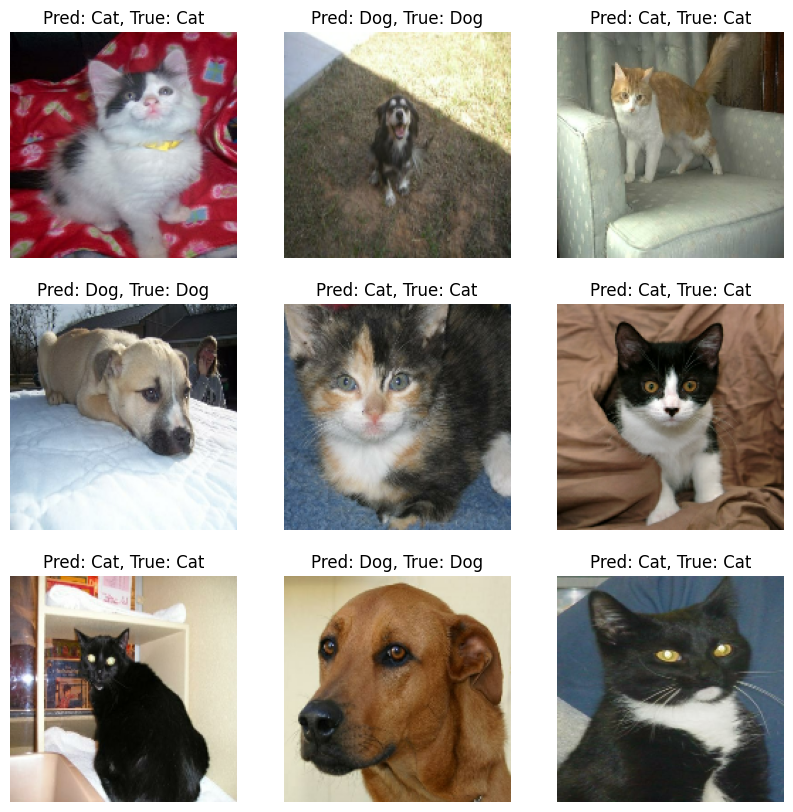

In [7]:
import matplotlib.pyplot as plt

class_names = ['Cat', 'Dog']

plt.figure(figsize=(10,10))
for images, labels in ds_test.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype("int32")
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Pred: {class_names[preds[i][0]]}, True: {class_names[labels[i]]}")
        plt.axis("off")
plt.show()